# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project, we will try to obtain data on the different restaurant categories in the city of **Chennai in Tamil Nadu, India** (It was chosen because it was my hometown) and cluster them into different categories based on the incidence of the restaurants in each neighborhood within a radius of 1km from the location centre. 


This report will be targeted at stakeholders that are interested in **opening a restaurant** in the city of chennai and desire to know the **different restaurant categories in Chennai** and the **cuisines of highest and lowest frequency** in each given area.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* The number of restaurants in a given neighborhood
* The different restaurant classifications
* The abundance or lack of restaurants in a given area as well as its distance from the city centre

The data sources used to extract the required information:
* The centre of the city of chennai is obtained using the **geocoder method**
* The different neighborhoods and their respective latitudes and longitudes have to be webscraped from **https://chennaiiq.com/chennai/latitude_longitude_areas.asp**
* The different venues in the individual neighborhoods are obtained using the **Foursquare API** using the explore? call
* The haversine formula is obtained from a website that works on calculating minimum distance along the earths surface between two points using their latitude and longitude values

**We import all the necessary libraries for the capstone project in the below cell**

In [120]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import urllib.request
from urllib.request import urlopen
import requests
import re
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm

**Do not use the next cell while viewing the file**

**While testing, viewing the entire rows and columns of the dataframe is very useful and can be done by setting all the set_option parameters to None**

In [121]:
pd.set_option('display.max_rows',20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Getting the latitudes and longitude of all neighborhoods in chennai

From analysing the internet, a website was found that listed the different Neighborhoods in the city of Chennai in the country of India and the respective location coordinates (latitudes and longitudes). The website URL was copied and was **webscarped** using the **Beautiful soup module** in python

In [122]:
url='https://chennaiiq.com/chennai/latitude_longitude_areas.asp'
page=requests.get(url)
soup=BeautifulSoup(page.text,'html.parser')
tables=soup.find_all('table',{'class':'TBox'})
tables

[<table align="center" border="0" cellpadding="3" cellspacing="1" class="TBox" width="70%">
 <tr class="tabH">
 <td colspan="4">List of Chennai City Latitude Longitude (Madras)</td>
 </tr>
 <tr class="tabH1">
 <td>S.No.</td>
 <td>Location</td>
 <td>Latitude</td>
 <td>Longitude</td>
 </tr>
 <tr class="tab"><td align="right">1</td><td> Adyar Bus Debot.</td><td> 12°59'50" N</td><td> 80°15'25" E</td></tr><tr class="tab"><td align="right">2</td><td> Adyar Signal</td><td> 13°00'23" N</td><td> 80°15'27" E</td></tr><tr class="tab"><td align="right">3</td><td> Alandur</td><td> 13°00'28" N</td><td> 80°12'35" E</td></tr><tr class="tab"><td align="right">4</td><td> Ambattur</td><td> 13°06'36" N</td><td> 80°10'12" E</td></tr><tr class="tab"><td align="right">5</td><td> Anna Arch</td><td> 13°04'28" N</td><td> 80°13'06" E</td></tr><tr class="tab"><td align="right">6</td><td> Anna Nagar Roundana</td><td> 13°05'04" N</td><td> 80°13'05" E</td></tr><tr class="tab"><td align="right">7</td><td> Anna Nagar 

### Getting the information into a dataframe

The information is demarcated by <tr> for the rows and <td> for the elements in the given row. By using find_all function and finding all the markers, we can extract the data into suitable lists and convert it to a pandas dataframe.

In [123]:
latitude=[]
Neighborhood=[]
longitude=[]
for table in tables:
    rows=table.find_all('tr')
    for row in rows:
        cells=row.find_all('td')
        if(len(cells)>1):
            location=cells[1]
            Neighborhood.append(location.text.strip())
                
            lat=cells[2]
            latitude.append(lat.text.strip())
                
            long=cells[3]
            longitude.append(long.text.strip())

In [124]:
df=pd.DataFrame(Neighborhood,columns=['Neighborhood'])
df['latitude']=latitude
df['longitude']=longitude
df.head()

,Neighborhood,latitude,longitude
0,Location,Latitude,Longitude
1,Adyar Bus Debot.,"12°59'50"" N","80°15'25"" E"
2,Adyar Signal,"13°00'23"" N","80°15'27"" E"
3,Alandur,"13°00'28"" N","80°12'35"" E"
4,Ambattur,"13°06'36"" N","80°10'12"" E"


In [125]:
df.shape

(106, 3)

In [126]:
df.drop(0,axis=0,inplace=True)
df.head()

,Neighborhood,latitude,longitude
1,Adyar Bus Debot.,"12°59'50"" N","80°15'25"" E"
2,Adyar Signal,"13°00'23"" N","80°15'27"" E"
3,Alandur,"13°00'28"" N","80°12'35"" E"
4,Ambattur,"13°06'36"" N","80°10'12"" E"
5,Anna Arch,"13°04'28"" N","80°13'06"" E"


In [127]:
df.shape

(105, 3)

The data that we obtained is in **degrees, minutes and seconds format** and is in the form of a string. It is not easy to feed this data into a folium map and is difficult to work with. By using **regular expressions** in python, we can extract and modify the different elements to match the **decimal format**

**Perform string operation to convert the location data from dms(degrees minutes seconds) to decimals**

The below chunk of code takes a latitude or longitude string with has its value in **DMS system and N/S/E/W** instead of **positive or negative signs**. This converts any location data to decimal location information.

In [128]:
def dms_to_dec_latlng(lat,long):
    min_pat=re.compile(r'[°](\d{2})[\']')
    sec_pat=re.compile(r'[\'](\d{2})[\"]')
    minutes_lat=(float(min_pat.search(lat).group(1)))/60
    seconds_lat=(float(sec_pat.search(lat).group(1)))/3600
    minutes_long=(float(min_pat.search(long).group(1)))/60
    seconds_long=(float(sec_pat.search(long).group(1)))/3600
    dec_lat=minutes_lat+seconds_lat
    dec_long=minutes_long+seconds_long
    pattern_south=re.compile(r'S$')
    pattern_west=re.compile(r'W$')
    south=pattern_south.search(lat)
    west=pattern_west.search(long)
    if (south==None):
        if (west==None):
            return [(float(lat[0:2])+dec_lat),(float(long[0:2])+dec_long)]
        else:
            return [(float(lat[0:2])+dec_lat),((float(long[0:2])+dec_long))*(-1)]
    else:
        if(west==None):
            return [((float(lat[0:2])+dec_lat))*(-1),(float(long[0:2])+dec_long)]
        else:
            return [((float(lat[0:2])+dec_lat))*(-1),((float(long[0:2])+dec_long))*(-1)]  

In [129]:
for index in range(1,(df.shape[0]+1)):
    lat=df.loc[index,'latitude']
    lng=df.loc[index,'longitude']
    fixed_loc=dms_to_dec_latlng(lat,lng)
    df.at[index,'latitude']=fixed_loc[0]
    df.at[index,'longitude']=fixed_loc[1]

In [130]:
df.head(105)

,Neighborhood,latitude,longitude
1,Adyar Bus Debot.,12.9972,80.2569
2,Adyar Signal,13.0064,80.2575
3,Alandur,13.0078,80.2097
4,Ambattur,13.11,80.17
5,Anna Arch,13.0744,80.2183
...,...,...,...
101,Velachery Bus Terminus,12.9758,80.2208
102,Villivakkam,13.11,80.2033
103,Vyasar Padi,13.1092,80.2625
104,Washermanpet,13.1086,80.2811


In [131]:
df=df.astype({'latitude':'float64','longitude':'float64'})

### To obtain the latitude and longitude of the centre of Chennai city

This is done using the geopy.geocoders library

In [132]:
from geopy.geocoders import Nominatim
import folium

In [133]:
address='Chennai, Tamil Nadu, India'
geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(address)
ch_lat = location.latitude
ch_lng = location.longitude
print(ch_lat,ch_lng)

13.0801721 80.2838331


### Plot a map centered on Chennai and showing the different neighborhoods in the city

In [134]:
chennai_map=folium.Map([ch_lat,ch_lng],zoom_start=11)
folium.CircleMarker([ch_lat,ch_lng],radius=12,popup='Chennai',fill=True,fill_color='#FF2D00',fill_opacity=0.8).add_to(chennai_map)

for lat,lng,neigh in zip(df.latitude,df.longitude,df.Neighborhood):
    folium.CircleMarker([lat,lng],radius=6,popup=neigh,fill=True,fill_color='#0032FF',fill_opacity=0.7).add_to(chennai_map)
chennai_map

## To access the Foursquare API and retrieve information regarding venues in Chennai

The client ID / Secret and version are prespecified to reduce the need to respecify where needed

In [135]:
CLIENT_ID = 'GIL5KFTBUZBWMUCEWGMC1NISL2E1BFTEWROCHKPEJDBQVU2M' 
CLIENT_SECRET = 'TBEJZQQAZ4SCSEZ2WZIJ2GPTOMO4C1ZQ4FI5OC5YBSJKT450'
VERSION = '20200404' 
radius=1000
LIMIT=100

**The foursquare explore? and categories? endpoint methods are tested and based on the data retrieved, the explore? method is utilized**

In [24]:
url_categories = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, ch_lat, ch_lng, radius, LIMIT)
print(url_categories)

https://api.foursquare.com/v2/venues/categories?&client_id=GIL5KFTBUZBWMUCEWGMC1NISL2E1BFTEWROCHKPEJDBQVU2M&client_secret=TBEJZQQAZ4SCSEZ2WZIJ2GPTOMO4C1ZQ4FI5OC5YBSJKT450&v=20200404&ll=13.0801721,80.2838331&radius=1000&limit=100


In [45]:
result=requests.get(url).json()
result

{'meta': {'code': 200, 'requestId': '5e9bfd899388d7002442f383'},
 'response': {'categories': [{'id': '4d4b7104d754a06370d81259',
    'name': 'Arts & Entertainment',
    'pluralName': 'Arts & Entertainment',
    'shortName': 'Arts & Entertainment',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
     'suffix': '.png'},
    'categories': [{'id': '56aa371be4b08b9a8d5734db',
      'name': 'Amphitheater',
      'pluralName': 'Amphitheaters',
      'shortName': 'Amphitheater',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
       'suffix': '.png'},
      'categories': []},
     {'id': '4fceea171983d5d06c3e9823',
      'name': 'Aquarium',
      'pluralName': 'Aquariums',
      'shortName': 'Aquarium',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
       'suffix': '.png'},
      'categories': []},
     {'id': '4bf58dd8d48988d1e1931735',
      'name': 'A

In [55]:
url_explore = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, ch_lat, ch_lng, radius, LIMIT)
result=requests.get(url).json()
result

{'meta': {'code': 200, 'requestId': '5e9c424d618f43001b71dc54'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Chennai',
  'headerFullLocation': 'Chennai',
  'headerLocationGranularity': 'city',
  'totalResults': 10,
  'suggestedBounds': {'ne': {'lat': 13.089172109000009,
    'lng': 80.29305558846286},
   'sw': {'lat': 13.071172090999992, 'lng': 80.27461061153713}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4cb9863b90c9a143bac487d6',
       'name': 'Fort Museum',
       'location': {'lat': 13.080618432998454,
        'lng': 80.2877188704723,
        'labeledLatLngs': [{'label': 'display',
          'lat': 13.080618432998454,
          'lng': 80.2877188704723}],
        'dis

### Using a loop  to perform foursquare api calls for each neighborhood and storing that data in a dataframe

In [76]:
def get_nearby_venues(names,latitude,longitude,radius=1000):
    venues_list=[]
    LIMIT=100
    for name,lat,lng in zip(names,latitude,longitude):
        url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        result=requests.get(url).json()['response']['groups'][0]['items']
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in result])
    
    nearby_venues=pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns=['Neighborhood','Area Latitude','Area Longitude','Venue Name','Venue Latitude','Venue Longitude','Venue Category']
    return (nearby_venues)

In [ ]:
chennai_venues=get_nearby_venues(df.Neighborhood,df.latitude,df.longitude)

## Since foursquare api has a limited number of calls, put the venues into a csv file to prevent calling it again later

In [78]:
chennai_venues.to_csv("chennai_venues.csv", header=True, index=False, encoding="utf-8")

In [136]:
chennai_venues=pd.read_csv('/Users/Karthik/Desktop/Python folder/chennai_venues.csv')
chennai_venues

,Neighborhood,Area Latitude,Area Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot.,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot.,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot.,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Debot.,12.997222,80.256944,Kovai Pazhamudir Nilayam,12.996522,80.259776,Fruit & Vegetable Store
4,Adyar Bus Debot.,12.997222,80.256944,Domino's Pizza,13.002000,80.254000,Pizza Place
...,...,...,...,...,...,...,...
3519,Woodlands Drive In,13.050000,80.251111,Wangs Kitchen,13.054777,80.258069,Chinese Restaurant
3520,Woodlands Drive In,13.050000,80.251111,The Accord Metropolitan Hotel Chennai,13.046173,80.246428,Nightclub
3521,Woodlands Drive In,13.050000,80.251111,Hotel Nandini Palace,13.047443,80.243199,Hotel
3522,Woodlands Drive In,13.050000,80.251111,Hotel Senthur,13.057353,80.254874,Indian Restaurant


### Unique venue categories in chennai_venues

The different types of venues in the city of chennai are obtained below

In [137]:
venue_list=chennai_venues['Venue Category'].unique()
print(venue_list.shape[0])
venue_list

182


array(['Middle Eastern Restaurant', 'Asian Restaurant', 'Café',
       'Fruit & Vegetable Store', 'Pizza Place', 'Fast Food Restaurant',
       "Women's Store", 'Indian Restaurant', 'Chinese Restaurant',
       'Diner', 'Sandwich Place', 'Gym', 'BBQ Joint', 'Hotel',
       'Multiplex', 'Movie Theater', 'Arcade', 'Breakfast Spot',
       'Electronics Store', 'Hotel Bar', 'Juice Bar', 'Bakery',
       'Ice Cream Shop', 'Pharmacy', 'Shopping Mall',
       'North Indian Restaurant', 'Vegetarian / Vegan Restaurant',
       'Grocery Store', 'Bookstore', 'Dessert Shop', 'Rock Club',
       'Lounge', 'Snack Place', 'Mediterranean Restaurant',
       'Italian Restaurant', 'Coffee Shop', 'Department Store',
       'Comfort Food Restaurant', 'Furniture / Home Store',
       'Gourmet Shop', 'Bus Station', 'Bar', 'Pool Hall', 'Airport',
       'Golf Course', 'Cafeteria', 'Supermarket', 'Gas Station',
       'Clothing Store', 'South Indian Restaurant', 'Scenic Lookout',
       'Food', 'Sporting Good

## By analysing the above list, a simple loop is written to extract only the various types of restaurants and food establishments into a dataframe for furthur analysis

In [138]:
Neighborhood=[]
venue=[]
category=[]
venue_lat=[]
venue_lng=[]
for i in range(0,chennai_venues.shape[0]):
    cell=chennai_venues.loc[i,'Venue Category']
    a=cell.split(" ")
    results=[a[-1]=='Restaurant',
             a[-1]=='Place',
             a[-1]=='Joint',
             a[0]=='Cafe',
             a[0]=='Diner',
             a[0]=='Steakhouse',
             a[0]=='Buffet',
             a[0]=='Bistro',
             a[0]=='Cafeteria',
             a[0]=='Food',
             a[0]=='Breakfast',
             a[-1]=='Breakfast',
             a[0]=='Dessert',
             a[0]=='Coffee',
             a[0]=='Juice']
    if any(results):
        Neighborhood.append(chennai_venues.loc[i,'Neighborhood'])
        venue.append(chennai_venues.loc[i,'Venue Name'])
        category.append(chennai_venues.loc[i,'Venue Category'])
        venue_lat.append(chennai_venues.loc[i,'Venue Latitude'])
        venue_lng.append(chennai_venues.loc[i,'Venue Longitude'])

In [139]:
dataset={'Neighborhood':Neighborhood,'Venue Name':venue,'Venue Latitude':venue_lat,'Venue Longitude':venue_lng,'Venue Category':category}
chennai_restaurants=pd.DataFrame(data=dataset)
print(chennai_restaurants.shape)
chennai_restaurants

(1850, 5)


,Neighborhood,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot.,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot.,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot.,Domino's Pizza,13.002000,80.254000,Pizza Place
3,Adyar Bus Debot.,"Adyar Ananda Bhavan, Besant Nagar",12.996678,80.258275,Fast Food Restaurant
4,Adyar Bus Debot.,Adyar Ananda Bhavan,13.005824,80.257368,Indian Restaurant
...,...,...,...,...,...
1845,Woodlands Drive In,Kumarakom,13.053263,80.248210,Indian Restaurant
1846,Woodlands Drive In,The Kati Roll Shop,13.047563,80.254954,Indian Restaurant
1847,Woodlands Drive In,Wangs Kitchen,13.054777,80.258069,Chinese Restaurant
1848,Woodlands Drive In,Hotel Senthur,13.057353,80.254874,Indian Restaurant


## Analysis <a name="analysis"></a>

### The different types of restaurants and their counts

**The different restaurant categories are obtained below**

In [140]:
restaurants=chennai_restaurants['Venue Category'].unique()
print(restaurants.shape[0])
restaurants

56


array(['Middle Eastern Restaurant', 'Asian Restaurant', 'Pizza Place',
       'Fast Food Restaurant', 'Indian Restaurant', 'Chinese Restaurant',
       'Diner', 'Sandwich Place', 'BBQ Joint', 'Breakfast Spot',
       'Juice Bar', 'North Indian Restaurant',
       'Vegetarian / Vegan Restaurant', 'Dessert Shop', 'Snack Place',
       'Mediterranean Restaurant', 'Italian Restaurant', 'Coffee Shop',
       'Comfort Food Restaurant', 'Cafeteria', 'South Indian Restaurant',
       'Food', 'Restaurant', 'Burger Joint', 'Bistro', 'Food Court',
       'Multicuisine Indian Restaurant', 'Korean Restaurant',
       'Rajasthani Restaurant', 'Steakhouse', 'Mexican Restaurant',
       'American Restaurant', 'Halal Restaurant', 'Bed & Breakfast',
       'African Restaurant', 'Kerala Restaurant', 'Thai Restaurant',
       'Buffet', 'Kebab Restaurant', 'Bengali Restaurant',
       'Japanese Curry Restaurant', 'Portuguese Restaurant',
       'Seafood Restaurant', 'Japanese Restaurant',
       'Molecular

**The total count of each venue category is obtained and placed in a table**

In [141]:
restaurants=chennai_restaurants.groupby(['Venue Category']).count()
restaurants.drop(['Venue Name','Venue Latitude','Venue Longitude'],axis=1,inplace=True)
restaurants.sort_values(by='Neighborhood',ascending=False,inplace=True)
restaurants

,Neighborhood
Venue Category,
Indian Restaurant,625
Chinese Restaurant,115
Pizza Place,92
Fast Food Restaurant,84
Coffee Shop,83
...,...
Andhra Restaurant,1
Food Truck,1
Bed & Breakfast,1


## Splitting the data into one dataframe with High frequency categories and one with low frequency categories

**The data is split up into high frequency restaurants and low frequency restaurants in order to perform clustering seperately without having one skew the other**

In [60]:
restaurants=restaurants.astype({'Neighborhood':'int64'})
restaurants.reset_index(inplace=True)

In [61]:
highfreq_rest=restaurants[restaurants['Neighborhood']>=10]
lowfreq_rest=restaurants[restaurants['Neighborhood']<10]

In [62]:
hfr=list(highfreq_rest['Venue Category'])
lfr=list(lowfreq_rest['Venue Category'])

In [63]:
chennai_rest_lowfreq=chennai_restaurants
for i in range(0,chennai_restaurants.shape[0]):
    cell=chennai_restaurants.loc[i,'Venue Category']
    for ele in hfr:
        if cell==ele:
            chennai_rest_lowfreq=chennai_rest_lowfreq.drop(i,axis=0)
            break

**This dataframe represents the distributiion of low frequcy restaurant catrgories in the city of chennai**

In [142]:
chennai_rest_lowfreq

,Neighborhood,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot.,Grand Sweets & Snacks,13.000950,80.261203,Diner
1,Adyar Signal,Bombay Brassiere,13.006961,80.256419,North Indian Restaurant
2,Adyar Signal,Daawat The Kebab Shop,13.006689,80.253728,North Indian Restaurant
3,Adyar Signal,Azzuri Bay,13.011110,80.253922,Mediterranean Restaurant
4,Adyar Signal,Grand Sweets & Snacks,13.000950,80.261203,Diner
...,...,...,...,...,...
133,Woodlands Drive In,Nando's,13.046237,80.256267,African Restaurant
134,Woodlands Drive In,Sree Mithai Sweets,13.054356,80.249891,Bengali Restaurant
135,Woodlands Drive In,Basil - With a Twist,13.049632,80.242210,Modern European Restaurant
136,Woodlands Drive In,Don Pepe Tex Mex,13.045617,80.258064,Mexican Restaurant


In [64]:
chennai_rest_lowfreq.shape

(138, 5)

In [65]:
chennai_rest_lowfreq.reset_index(inplace=True)
chennai_restaurants.reset_index(inplace=True)

**To find the mutually disjoint sets of chennai_restaurants and the low_freq_restaurants**

In [66]:
chennai_rest_highfreq=pd.concat([chennai_restaurants,chennai_rest_lowfreq,chennai_rest_lowfreq]).drop_duplicates(keep=False)

In [67]:
chennai_rest_highfreq.reset_index(inplace=True)

In [68]:
chennai_restaurants.drop(['index'],axis=1,inplace=True)
chennai_rest_lowfreq.drop(['index'],axis=1,inplace=True)
chennai_rest_highfreq.drop(['level_0','index'],axis=1,inplace=True)

In [143]:
chennai_rest_highfreq

,Neighborhood,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot.,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot.,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot.,Domino's Pizza,13.002000,80.254000,Pizza Place
3,Adyar Bus Debot.,"Adyar Ananda Bhavan, Besant Nagar",12.996678,80.258275,Fast Food Restaurant
4,Adyar Bus Debot.,Adyar Ananda Bhavan,13.005824,80.257368,Indian Restaurant
...,...,...,...,...,...
1707,Woodlands Drive In,Kumarakom,13.053263,80.248210,Indian Restaurant
1708,Woodlands Drive In,The Kati Roll Shop,13.047563,80.254954,Indian Restaurant
1709,Woodlands Drive In,Wangs Kitchen,13.054777,80.258069,Chinese Restaurant
1710,Woodlands Drive In,Hotel Senthur,13.057353,80.254874,Indian Restaurant


## A small note to keep track of the different dataframe names used in the notebook

**chennai_venues -> Different venues in chennai**

**chennai_restaurants -> Restaurants in chennai**                               

**restaurants -> Categories of diff restaurants and their count**

**chennai_rest_highfreq -> High frequency restaurant distribution**

**chennai_rest_lowfreq -> Low frequency restaurant distribution**

## The pandas get dummies method is used on the high and low frequency dataframes to prepare them for kmeans clustering

In [70]:
def dummies(dataframe):
    final=pd.get_dummies(dataframe[['Venue Category']],prefix="",prefix_sep="")
    final['Neighborhood']=dataframe['Neighborhood']
    fixed_columns=[final.columns[-1]]+list(final.columns[:-1])
    final=final[fixed_columns]
    final=final.groupby(['Neighborhood']).mean()
    return final

In [71]:
hf_rest_onehot=dummies(chennai_rest_highfreq)
hf_rest_onehot

,Asian Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Food Court,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,
AVM Studio,0.095238,0.047619,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.095238,0.0,0.380952,0.047619,0.0,0.000000,0.0,0.000000,0.095238,0.047619,0.000000,0.047619,0.047619,0.000000,0.095238
Adyar Bus Debot.,0.090909,0.045455,0.0,0.045455,0.0,0.0,0.045455,0.000000,0.000000,0.090909,0.0,0.409091,0.000000,0.0,0.045455,0.0,0.045455,0.136364,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000
Adyar Signal,0.029412,0.000000,0.0,0.000000,0.0,0.0,0.029412,0.029412,0.058824,0.058824,0.0,0.500000,0.029412,0.0,0.058824,0.0,0.000000,0.088235,0.000000,0.029412,0.029412,0.000000,0.000000,0.058824
Alandur,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ambattur,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Velachery Bus Terminus,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.074074,0.037037,0.000000,0.185185,0.0,0.407407,0.037037,0.0,0.000000,0.0,0.000000,0.074074,0.111111,0.000000,0.037037,0.000000,0.000000,0.037037
Villivakkam,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Vyasar Padi,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [72]:
lf_rest_onehot=dummies(chennai_rest_lowfreq)
lf_rest_onehot

,African Restaurant,American Restaurant,Andhra Restaurant,Bed & Breakfast,Bengali Restaurant,Burrito Place,Cafeteria,Comfort Food Restaurant,Diner,Falafel Restaurant,Food,Food & Drink Shop,Food Truck,Fried Chicken Joint,Halal Restaurant,Hyderabadi Restaurant,Japanese Curry Restaurant,Kerala Restaurant,Korean Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Portuguese Restaurant,Rajasthani Restaurant,Russian Restaurant,Seafood Restaurant,Steakhouse
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adyar Bus Debot.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adyar Signal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.20,0.0,0.00,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0
Alandur,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anna Arch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CIPET,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Valluvar Kottam,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Vani Mahal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.25,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Velachery Bus Terminus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Performing k means clustering on the datasets

In [73]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [74]:
hf_rest_onehot.reset_index(inplace=True)
lf_rest_onehot.reset_index(inplace=True)

In [75]:
hf_clustering=hf_rest_onehot.drop('Neighborhood',1)
lf_clustering=lf_rest_onehot.drop('Neighborhood',1)

### Looping through the different cluster values choosing the k value at the elbow point based on the sum of squares error

In [76]:
sse_hf={}
sse_lf={}
for k in range(1,20):
    kmeans_hf=KMeans(n_clusters=k).fit(hf_clustering)
    kmeans_lf=KMeans(n_clusters=k).fit(lf_clustering)
    sse_hf[k]=kmeans_hf.inertia_
    sse_lf[k]=kmeans_lf.inertia_

**k=7 is the elbow point for the high frequency data**

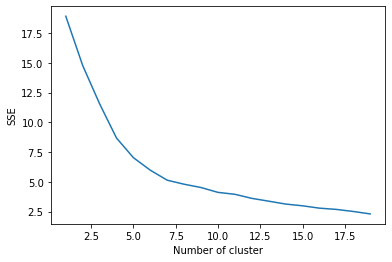

In [77]:
plt.figure()
plt.plot(list(sse_hf.keys()), list(sse_hf.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

**around k=15 seems to be the elbow point here**

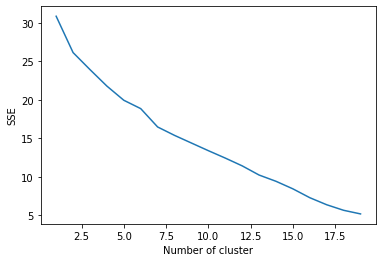

In [78]:
plt.figure()
plt.plot(list(sse_lf.keys()), list(sse_lf.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### The values of k are chosen as 7 and 15 for the high and low frequency sets

In [79]:
k_hf=7
k_lf=15
kmeans_hf=KMeans(n_clusters=k_hf).fit(hf_clustering)
kmeans_lf=KMeans(n_clusters=k_lf).fit(lf_clustering)

### Create a dataframe that lists the different categories in descending order of their predominance in an area and the cluster labels are added to the dataframe

In [80]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [81]:
def column_names(num_top_venues):
    indicators = ['st', 'nd', 'rd']
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues-1):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))
    
    return columns
            
hf_rest_sorted=pd.DataFrame(columns=column_names(hf_rest_onehot.shape[1]))
lf_rest_sorted=pd.DataFrame(columns=column_names(lf_rest_onehot.shape[1]))

hf_rest_sorted['Neighborhood']=hf_rest_onehot['Neighborhood']
lf_rest_sorted['Neighborhood']=lf_rest_onehot['Neighborhood']

for ind in np.arange(hf_rest_onehot.shape[0]):
    hf_rest_sorted.iloc[ind, 1:] = return_most_common_venues(hf_rest_onehot.iloc[ind, :], hf_rest_onehot.shape[1])
                            
for ind in np.arange(lf_rest_onehot.shape[0]):
    lf_rest_sorted.iloc[ind, 1:] = return_most_common_venues(lf_rest_onehot.iloc[ind, :], lf_rest_onehot.shape[1])

In [82]:
hf_rest_sorted.insert(1,'Cluster Labels',kmeans_hf.labels_)
lf_rest_sorted.insert(1,'Cluster Labels',kmeans_lf.labels_)

In [83]:
hf_rest_sorted

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue
0,AVM Studio,0,Indian Restaurant,Pizza Place,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Italian Restaurant,BBQ Joint,Restaurant,South Indian Restaurant,Snack Place,Juice Bar,Japanese Restaurant,Kebab Restaurant,Thai Restaurant,Food Court,Middle Eastern Restaurant,Dessert Shop,Coffee Shop,Chinese Restaurant,Burger Joint,Buffet,Breakfast Spot,Bistro,Sandwich Place
1,Adyar Bus Debot.,0,Indian Restaurant,Pizza Place,Fast Food Restaurant,Asian Restaurant,Sandwich Place,BBQ Joint,Middle Eastern Restaurant,Juice Bar,Breakfast Spot,Chinese Restaurant,Dessert Shop,Bistro,Buffet,Burger Joint,Coffee Shop,South Indian Restaurant,Restaurant,Food Court,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Snack Place,Vegetarian / Vegan Restaurant
2,Adyar Signal,0,Indian Restaurant,Pizza Place,Dessert Shop,Fast Food Restaurant,Juice Bar,Vegetarian / Vegan Restaurant,Asian Restaurant,Chinese Restaurant,Sandwich Place,Italian Restaurant,Snack Place,Coffee Shop,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Restaurant,Middle Eastern Restaurant,Food Court,Thai Restaurant,Japanese Restaurant,Kebab Restaurant,South Indian Restaurant
3,Alandur,2,Indian Restaurant,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Food Court,Vegetarian / Vegan Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
4,Ambattur,3,Pizza Place,Vegetarian / Vegan Restaurant,Food Court,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Indian Restaurant,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Velachery Bus Terminus,0,Indian Restaurant,Fast Food Restaurant,Restaurant,Chinese Restaurant,Pizza Place,Italian Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Snack Place,Kebab Restaurant,Juice Bar,Japanese Restaurant,Middle Eastern Restaurant,Thai Restaurant,Food Court,Sandwich Place,Dessert Shop,South Indian Restaurant,Burger Joint,Buffet,Breakfast Spot,Bistro,BBQ Joint,Asian Restaurant
97,Villivakkam,2,Indian Restaurant,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Food Court,Vegetarian / Vegan Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
98,Vyasar Padi,3,Pizza Place,Vegetarian / Vegan Restaurant,Food Court,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Indian Restaurant,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
99,Woodlands Drive In,0,Indian Restaurant,Chinese Restaurant,Sandwich Place,Coffee Shop,Italian Restaurant,Restaurant,Pizza Place,Middle Eastern Restaurant,Juice Bar,BBQ Joint,Thai

In [84]:
lf_rest_sorted

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue
0,Adyar Bus Debot.,4,Diner,Steakhouse,Seafood Restaurant,American Restaurant,Andhra Restaurant,Bed & Breakfast,Bengali Restaurant,Burrito Place,Cafeteria,Comfort Food Restaurant,Falafel Restaurant,Food,Food & Drink Shop,Food Truck,Fried Chicken Joint,Halal Restaurant,Hyderabadi Restaurant,Japanese Curry Restaurant,Kerala Restaurant,Korean Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Portuguese Restaurant,Rajasthani Restaurant,Russian Restaurant,African Restaurant
1,Adyar Signal,8,North Indian Restaurant,Comfort Food Restaurant,Mediterranean Restaurant,Diner,Steakhouse,Food Truck,Food & Drink Shop,Food,Falafel Restaurant,Cafeteria,Halal Restaurant,Burrito Place,Bengali Restaurant,Bed & Breakfast,Andhra Restaurant,American Restaurant,Fried Chicken Joint,Hyderabadi Restaurant,Seafood Restaurant,Japanese Curry Restaurant,Kerala Restaurant,Korean Restaurant,Malay Restaurant,Mexican Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Multicuisine Indian Restaurant,New American Restaurant,Portuguese Restaurant,Rajasthani Restaurant,Russian Restaurant,African Restaurant
2,Alandur,1,Cafeteria,Steakhouse,Seafood Restaurant,American Restaurant,Andhra Restaurant,Bed & Breakfast,Bengali Restaurant,Burrito Place,Comfort Food Restaurant,Diner,Falafel Restaurant,Food,Food & Drink Shop,Food Truck,Fried Chicken Joint,Halal Restaurant,Hyderabadi Restaurant,Japanese Curry Restaurant,Kerala Restaurant,Korean Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Portuguese Restaurant,Rajasthani Restaurant,Russian Restaurant,African Restaurant
3,Anna Arch,10,Food,Steakhouse,Seafood Restaurant,American Restaurant,Andhra Restaurant,Bed & Breakfast,Bengali Restaurant,Burrito Place,Cafeteria,Comfort Food Restaurant,Diner,Falafel Restaurant,Food & Drink Shop,Food Truck,Fried Chicken Joint,Halal Restaurant,Hyderabadi Restaurant,Japanese Curry Restaurant,Kerala Restaurant,Korean Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Portuguese Restaurant,Rajasthani Restaurant,Russian Restaurant,African Restaurant
4,CIPET,1,Cafeteria,Steakhouse,Seafood Restaurant,American Restaurant,Andhra Restaurant,Bed & Breakfast,Bengali Restaurant,Burrito Place,Comfort Food Restaurant,Diner,Falafel Restaurant,Food,Food & Drink Shop,Food Truck,Fried Chicken Joint,Halal Restaurant,Hyderabadi Restaurant,Japanese Curry Restaurant,Kerala Restaurant,Korean Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Portuguese Restaurant,Rajasthani Restaurant,Russian Restaurant,African Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

## Analysing clusters of high frequency restaurants dataframe

**High Frequency Restaurant Categories**

**Cluster 0** - Areas with very high incidence of **Indian Restaurants** , followed by a high incidence of **Pizza Places** and **Chinese restaurants**

Have a low incidence of **BBQ joints**, **Asian restaurants(excluding chinese)** and **cafe/coffee shops**

In [95]:
hf_rest_sorted.loc[hf_rest_sorted['Cluster Labels']==0,:]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue
0,AVM Studio,0,Indian Restaurant,Pizza Place,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Italian Restaurant,BBQ Joint,Restaurant,South Indian Restaurant,Snack Place,Juice Bar,Japanese Restaurant,Kebab Restaurant,Thai Restaurant,Food Court,Middle Eastern Restaurant,Dessert Shop,Coffee Shop,Chinese Restaurant,Burger Joint,Buffet,Breakfast Spot,Bistro,Sandwich Place
1,Adyar Bus Debot.,0,Indian Restaurant,Pizza Place,Fast Food Restaurant,Asian Restaurant,Sandwich Place,BBQ Joint,Middle Eastern Restaurant,Juice Bar,Breakfast Spot,Chinese Restaurant,Dessert Shop,Bistro,Buffet,Burger Joint,Coffee Shop,South Indian Restaurant,Restaurant,Food Court,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Snack Place,Vegetarian / Vegan Restaurant
2,Adyar Signal,0,Indian Restaurant,Pizza Place,Dessert Shop,Fast Food Restaurant,Juice Bar,Vegetarian / Vegan Restaurant,Asian Restaurant,Chinese Restaurant,Sandwich Place,Italian Restaurant,Snack Place,Coffee Shop,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Restaurant,Middle Eastern Restaurant,Food Court,Thai Restaurant,Japanese Restaurant,Kebab Restaurant,South Indian Restaurant
13,CIPET,0,Indian Restaurant,Asian Restaurant,Restaurant,Dessert Shop,South Indian Restaurant,Fast Food Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Food Court,Snack Place,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Sandwich Place,Vegetarian / Vegan Restaurant
14,CIT Nagar Roundana,0,Indian Restaurant,Italian Restaurant,Chinese Restaurant,Fast Food Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,South Indian Restaurant,Restaurant,Sandwich Place,Snack Place,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Pizza Place,Coffee Shop,Middle Eastern Restaurant,Food Court,Japanese Restaurant,Juice Bar,Kebab Restaurant,Dessert Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Valluvar Kottam,0,Indian Restaurant,Chinese Restaurant,Coffee Shop,Pizza Place,BBQ Joint,Italian Restaurant,Asian Restaurant,South Indian Restaurant,Restaurant,Sandwich Place,Dessert Shop,Japanese Restaurant,Thai Restaurant,Fast Food Restaurant,Burger Joint,Bistro,Breakfast Spot,Buffet,Middle Eastern Restaurant,Snack Place,Kebab Restaurant,Food Court,Juice Bar,Vegetarian / Vegan Restaurant
95,Vani Mahal,0,Indian Restaurant,Coffee Shop,Restaurant,Italian Restaurant,BBQ Joint,Chinese Restaurant,Pizza Place,Dessert Shop,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Juice Bar,Sandwich Place,South Indian Restaurant,Japanese Restaurant,Thai Restaurant,Food Court,Kebab Restaurant,Middle Eastern Restaurant,Snack Place,Burger Joint,Buffet,Breakfast Spot,Bistro,Asian Restaurant
96,Velachery Bus Terminus,0,Indian Restaurant,Fast Food Restaurant,Restaurant,Chinese Restaurant,Pizza Place,Italian Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Snack Place,Kebab Restaurant,Juice Bar,Japanese Restaurant,Middle Eastern Restaurant,Thai Restaurant,Food Court,Sandwich Place,Dessert Shop,South Indian Restaurant,Burger Joint,Buffet,Breakfast Spot,Bistro,BBQ Joint,Asian Restaurant
99,Woodlands Drive In,0,Indian Restaurant,Chinese Restaurant,Sandwich Place,Coffee Shop,Italian Restaurant,Restaurant,Pizza Place,Middle Eastern Restaurant,Juice Bar,B

**Since only one restaurant falls under this category, we drop this cluster since it isnt statistially significant**

In [86]:
hf_rest_sorted.loc[hf_rest_sorted['Cluster Labels']==4,:]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue
89,Tiruvottiyur,4,Asian Restaurant,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Food Court,Vegetarian / Vegan Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Indian Restaurant


**Cluster 5** - Very high incidence of **Indian (both North and South) restaurants** as well as a high incidence of **Chinese restaurants and BBQ joints**

Low incidence of **Non chinese Asian restaurants**, **Burger and buffet joints** and **general snack places and sandwich shops**

In [96]:
hf_rest_sorted.loc[hf_rest_sorted['Cluster Labels']==5,:]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue
5,Anna Arch,5,Fast Food Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Juice Bar,BBQ Joint,Chinese Restaurant,Coffee Shop,Indian Restaurant,South Indian Restaurant,Kebab Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Food Court,Restaurant,Dessert Shop,Sandwich Place,Snack Place,Burger Joint,Buffet,Breakfast Spot,Bistro,Asian Restaurant
6,Anna Nagar Roundana,5,Indian Restaurant,Chinese Restaurant,Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Juice Bar,Pizza Place,BBQ Joint,Bistro,Burger Joint,South Indian Restaurant,Snack Place,Sandwich Place,Asian Restaurant,Dessert Shop,Food Court,Thai Restaurant,Italian Restaurant,Buffet,Breakfast Spot,Japanese Restaurant,Kebab Restaurant
7,Anna Nagar West Terminus,5,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,BBQ Joint,Pizza Place,Italian Restaurant,Snack Place,Dessert Shop,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Food Court,South Indian Restaurant,Sandwich Place,Thai Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Restaurant,Asian Restaurant
9,Anna University Entrance,5,Snack Place,Chinese Restaurant,Juice Bar,Vegetarian / Vegan Restaurant,Food Court,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Coffee Shop,Dessert Shop,Fast Food Restaurant,Indian Restaurant,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,South Indian Restaurant,Asian Restaurant
11,Ayyappa Temple,5,Indian Restaurant,Restaurant,BBQ Joint,Juice Bar,Vegetarian / Vegan Restaurant,Asian Restaurant,South Indian Restaurant,Dessert Shop,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Sandwich Place,Pizza Place,Food Court,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Snack Place,Kebab Restaurant,Middle Eastern Restaurant,Fast Food Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Thiruvanmiyur Bus Terminus,5,Indian Restaurant,BBQ Joint,Bistro,Sandwich Place,Pizza Place,Burger Joint,Juice Bar,Chinese Restaurant,Fast Food Restaurant,Breakfast Spot,Buffet,Coffee Shop,Dessert Shop,Vegetarian / Vegan Restaurant,Food Court,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Middle Eastern Restaurant,Restaurant,Snack Place,South Indian Restaurant,Asian Restaurant
87,Thiruvanmiyur Junction,5,Indian Restaurant,BBQ Joint,Bistro,Sandwich Place,Pizza Place,Burger Joint,Juice Bar,Chinese Restaurant,Food Court,Fast Food Restaurant,Breakfast Spot,Buffet,Coffee Shop,Dessert Shop,Vegetarian / Vegan Restaurant,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Middle Eastern Restaurant,Restaurant,Snack Place,South Indian Restaurant,Asian Restaurant
88,Tidel Park,5,Indian Restaurant,Food Court,Sandwich Place,Bistro,Breakfast Spot,Chinese Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Snack Place,Kebab Restaurant,Juice Bar,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Middle Eastern Restaurant,Dessert Shop,Coffee Shop,Restaurant,Burger Joint,Buffet,South Indian Restaurant,BBQ Joint,Asian Restaurant
92,Triplicane Railway Station,5,Indian Restaurant,Middle Eastern Restaurant,Juice Bar,Vegetarian / Vegan Restaurant,Sandwich Pla

**Cluster 2** - Very high incidence of **Indian Restaurants** followed by a high incidence of **Dessert shops and Breakfast shops**

Low incidence of **South indian**, **snacking and sandwich places**, **Pizza places**, **fast food restaurants** and **Italian and thai restaurants** 

In [93]:
hf_rest_sorted.loc[hf_rest_sorted['Cluster Labels']==2,:]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue
3,Alandur,2,Indian Restaurant,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Food Court,Vegetarian / Vegan Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
8,Anna Statue,2,Indian Restaurant,Dessert Shop,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Food Court,Vegetarian / Vegan Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
10,Avadi,2,Indian Restaurant,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Food Court,Vegetarian / Vegan Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
21,Chintadripet,2,Indian Restaurant,Dessert Shop,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Food Court,Vegetarian / Vegan Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
40,Kathipara Junction,2,Indian Restaurant,Breakfast Spot,Pizza Place,Food Court,BBQ Joint,Bistro,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
44,Le Meridian,2,Indian Restaurant,Breakfast Spot,Pizza Place,Food Court,BBQ Joint,Bistro,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
64,Parrys Bus Stand,2,Indian Restaurant,Restaurant,Food Court,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
70,Royapuram,2,Indian Restaurant,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Food Court,Vegetarian / Vegan Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
91,Triplicane,2,Indian Restaurant,Middle Eastern Restaurant,Breakfast Spot,Dessert Shop,Vegetarian / Vegan Restaurant,Restaurant,Snack Place,BBQ Joint,Bistro,South Indian Restaurant,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Pizza Place,Food Court,Thai Restaurant,

**Cluster 6** - A very high incidence of **Vegetarian and Thai restaurants** and a high incidence of **BBQ and bistro joints**

Low incidence of **Pizza places**, **snacking places**, and **exotic cuisines(apart from thai)**

In [94]:
hf_rest_sorted.loc[hf_rest_sorted['Cluster Labels']==6,:]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue
42,Korukkupet,6,Vegetarian / Vegan Restaurant,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Food Court,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
68,Poonamallee,6,Vegetarian / Vegan Restaurant,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Food Court,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
78,TVS Signal,6,Vegetarian / Vegan Restaurant,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Food Court,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
90,Tondiarpet,6,Vegetarian / Vegan Restaurant,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Food Court,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant


**Cluster 3** - Very high incidence of **Pizza places** and a high incidence of **Vegan restaurants and BBQ joints**

A small sample so difficult to gauge the lacking parameters

In [90]:
hf_rest_sorted.loc[hf_rest_sorted['Cluster Labels']==3,:]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue
4,Ambattur,3,Pizza Place,Vegetarian / Vegan Restaurant,Food Court,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Indian Restaurant,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
12,Basin Bridge,3,Pizza Place,Vegetarian / Vegan Restaurant,Food Court,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Indian Restaurant,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
98,Vyasar Padi,3,Pizza Place,Vegetarian / Vegan Restaurant,Food Court,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Indian Restaurant,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant


**Cluster 1** - Very high incidence of **Fast food restaurants** followed by a high incidence of **Vegan/Vegetarian restaurants**

Very lacking in any form of exotc cuisine (italian, middle easter, japanese) and is one of few clusters showing a lack in **Indian Restaurants** which primarily implies north indian restaurants

In [89]:
hf_rest_sorted.loc[hf_rest_sorted['Cluster Labels']==1,:]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue
16,Chennai Airport,1,Fast Food Restaurant,South Indian Restaurant,Pizza Place,Coffee Shop,Dessert Shop,Vegetarian / Vegan Restaurant,Food Court,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Indian Restaurant,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Restaurant,Sandwich Place,Snack Place,Asian Restaurant
18,Chennai Mofussil Bus Terminas (CMBT),1,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Food Court,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Coffee Shop,Dessert Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
43,Koyambedu Omni Bus Terminus,1,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Food Court,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
45,Light House,1,Fast Food Restaurant,Coffee Shop,Indian Restaurant,Sandwich Place,Pizza Place,Chinese Restaurant,Italian Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Dessert Shop,Vegetarian / Vegan Restaurant,Food Court,Thai Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Restaurant,Snack Place,South Indian Restaurant,Asian Restaurant
47,MIOT Hospital,1,Fast Food Restaurant,Indian Restaurant,South Indian Restaurant,Food Court,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Vegetarian / Vegan Restaurant,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,Asian Restaurant
53,Minambakkam,1,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Food Court,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant


### Cluster Summary

In [97]:
cluster_labels=[5,3,6,1,4,0,2]
high_incidence=["Indian followed by Chinese and BBQ joints",
                "Pizza place followed by vegetarian & BBQ joints",
                "Vegetarian & Thai followed by Vegan & BBQ joints",
                "Fast food restaurants followed by vegan restaurants",
                "Not statistically significant",
                "Indian followed by Pizza & Chinese",
                "Indian followed by Dessert & Breakfast shops"]
low_incidence=["Non chinese asian, burger, buffet, snacking",
               "Exotic restaurants",
               "Pizza places, snacking places & exotic cuisines",
               "Indian restaurants followed by exotic cuisines",
               "Not statistically significant",
               "BBQ, asian, Cafe & coffe shops",
               "South Indian, Snacking & Sandwich places, Pizza places, fast food restaurants & Italian & thai restaurants"]
dataset={'Cluster Labels':cluster_labels,'High Frequency locations':high_incidence,'Low Frequency Locations':low_incidence}

In [101]:
hf_restaurant_classification=pd.DataFrame(data=dataset)
hf_restaurant_classification.sort_values(by=['Cluster Labels'],inplace=True)
hf_restaurant_classification.reset_index(drop=True,inplace=True)
hf_restaurant_classification

,Cluster Labels,High Frequency locations,Low Frequency Locations
0,0,Indian followed by Pizza & Chinese,"BBQ, asian, Cafe & coffe shops"
1,1,Fast food restaurants followed by vegan restaurants,Indian restaurants followed by exotic cuisines
2,2,Indian followed by Dessert & Breakfast shops,"South Indian, Snacking & Sandwich places, Pizza places, fast food restaurants & Italian & thai restaurants"
3,3,Pizza place followed by vegetarian & BBQ joints,Exotic restaurants
4,4,Not statistically significant,Not statistically significant
5,5,Indian followed by Chinese and BBQ joints,"Non chinese asian, burger, buffet, snacking"
6,6,Vegetarian & Thai followed by Vegan & BBQ joints,"Pizza places, snacking places & exotic cuisines"


**Note:- The distance between the different locations have not been found here as its primary goal is to provide the various categories and their distributions**

**However, the a function has been included below to determine the distance of a location from the city centre and can be used easily to gauge the relative accessibilitiy of each neighborhood while taking decisions**

In [102]:
from math import sin,cos,atan2,pi,sqrt
def get_distance(lat1,lng1,lat2,lng2):
    p=pi/180
    del_lat=(lat2-lat1)*p
    del_lng=(lng2-lng1)*p
    lat1*=p
    lat2*=p
    R=6371 ##in kms
    
    a=(((sin(del_lat/2))**2)+(cos(lat1)*cos(lat2))*((sin(del_lng/2))**2))
    c=2*(atan2(sqrt(a),sqrt(1-a)))
    d=R*c
    return d

In [103]:
print("{} kms".format(get_distance(12.997222,80.256944,13.0801721,80.2838331)))

9.6726428077056 kms


**This can be used as a filter**

**The user can specify a radius and by adding the distane parameter to the dataframe containing the cluster information, we can use groupby to get the analysis of the neighborhoods within radius**

In [108]:
cluster_df=pd.merge(df,hf_rest_sorted,on='Neighborhood')
cluster_df

,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue
0,Adyar Bus Debot.,12.997222,80.256944,0,Indian Restaurant,Pizza Place,Fast Food Restaurant,Asian Restaurant,Sandwich Place,BBQ Joint,Middle Eastern Restaurant,Juice Bar,Breakfast Spot,Chinese Restaurant,Dessert Shop,Bistro,Buffet,Burger Joint,Coffee Shop,South Indian Restaurant,Restaurant,Food Court,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Snack Place,Vegetarian / Vegan Restaurant
1,Adyar Signal,13.006389,80.257500,0,Indian Restaurant,Pizza Place,Dessert Shop,Fast Food Restaurant,Juice Bar,Vegetarian / Vegan Restaurant,Asian Restaurant,Chinese Restaurant,Sandwich Place,Italian Restaurant,Snack Place,Coffee Shop,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Restaurant,Middle Eastern Restaurant,Food Court,Thai Restaurant,Japanese Restaurant,Kebab Restaurant,South Indian Restaurant
2,Alandur,13.007778,80.209722,2,Indian Restaurant,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Food Court,Vegetarian / Vegan Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
3,Ambattur,13.110000,80.170000,3,Pizza Place,Vegetarian / Vegan Restaurant,Food Court,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Indian Restaurant,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restaurant
4,Anna Arch,13.074444,80.218333,5,Fast Food Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Juice Bar,BBQ Joint,Chinese Restaurant,Coffee Shop,Indian Restaurant,South Indian Restaurant,Kebab Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Food Court,Restaurant,Dessert Shop,Sandwich Place,Snack Place,Burger Joint,Buffet,Breakfast Spot,Bistro,Asian Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Vani Mahal,13.044722,80.240278,0,Indian Restaurant,Coffee Shop,Restaurant,Italian Restaurant,BBQ Joint,Chinese Restaurant,Pizza Place,Dessert Shop,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Juice Bar,Sandwich Place,South Indian Restaurant,Japanese Restaurant,Thai Restaurant,Food Court,Kebab Restaurant,Middle Eastern Restaurant,Snack Place,Burger Joint,Buffet,Breakfast Spot,Bistro,Asian Restaurant
97,Velachery Bus Terminus,12.975833,80.220833,0,Indian Restaurant,Fast Food Restaurant,Restaurant,Chinese Restaurant,Pizza Place,Italian Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Snack Place,Kebab Restaurant,Juice Bar,Japanese Restaurant,Middle Eastern Restaurant,Thai Restaurant,Food Court,Sandwich Place,Dessert Shop,South Indian Restaurant,Burger Joint,Buffet,Breakfast Spot,Bistro,BBQ Joint,Asian Restaurant
98,Villivakkam,13.110000,80.203333,2,Indian Restaurant,Thai Restaurant,BBQ Joint,Bistro,Breakfast Spot,Buffet,Burger Joint,Chinese Restaurant,Coffee Shop,Dessert Shop,Fast Food Restaurant,Food Court,Vegetarian / Vegan Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Snack Place,South Indian Restaurant,Asian Restau

## Plotting a map of chennai and coloring the different neighborhoods based on their cluster labels

In [116]:
chennai_map=folium.Map([ch_lat,ch_lng],zoom_start=11)

colors_array = cm.rainbow(np.linspace(0, 1, k_hf))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat,lng,neighborhood,cluster_label in zip(cluster_df.latitude,cluster_df.longitude,cluster_df.Neighborhood,cluster_df['Cluster Labels']):
    labels="{} Cluster:{}".format(neighborhood,cluster_label)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=labels,
        color=rainbow[cluster_label],
        fill=True,
        fill_color=rainbow[cluster_label],
        fill_opacity=0.7,
        parse_html=False).add_to(chennai_map)
    
chennai_map

## The above map corresponds to the below clusters. The clusters have been analysed and their prominent charactristics in the desired context have been listed

In [117]:
hf_restaurant_classification

,Cluster Labels,High Frequency locations,Low Frequency Locations
0,0,Indian followed by Pizza & Chinese,"BBQ, asian, Cafe & coffe shops"
1,1,Fast food restaurants followed by vegan restaurants,Indian restaurants followed by exotic cuisines
2,2,Indian followed by Dessert & Breakfast shops,"South Indian, Snacking & Sandwich places, Pizza places, fast food restaurants & Italian & thai restaurants"
3,3,Pizza place followed by vegetarian & BBQ joints,Exotic restaurants
4,4,Not statistically significant,Not statistically significant
5,5,Indian followed by Chinese and BBQ joints,"Non chinese asian, burger, buffet, snacking"
6,6,Vegetarian & Thai followed by Vegan & BBQ joints,"Pizza places, snacking places & exotic cuisines"


### The same analysis is carried out on the low frequency restaurants. Due to their overwhelmingly low incidence of less than 5-6 of those venues acorss the city, the stakeholders could choose either one of those relatively confidently but the model is already done so just analysing the cluster woud be required which is easy and identical to what we've done above.

## Results and Discussion <a name="results"></a>

The entire purpose behind this project was to provide an insight into the distribution of restaurants in the city of Chennai in Tamil Nade, India. The analysis focuses on retrieving all the venues in chennai, accurately filtering out the restaurants and clustering them to analyse the neighborhoods. On our analysis, we can clearly see that certain locations clearly have a greater incidence of certain restaurants and a clear lack of others. 

The analysis showed an exceptionally high number of indian restaurants and a reasonably high number of chinese restaurants. Some very key insights were derived in the anaysis. For example, the few major areas that had a major lack of indian restaurants were identified which could be cruical for stakeholders interested in entering the indian restaurant game. Similar insights have shown certain key areas that are definately not suitable for opening massive chain categories like pizza places, vegetarian restaurants etc. For a future design, the data could be fed into an app or olatform where based on the type of restaurant or choice of area, the cluster data, simlilar neighborhoods, distribution of restaurants etc can be easily obtained.

## Conclusion <a name="conclusion"></a>

The purpose of this project was the identify the various restaurant categories and their quantitative distribution in the city of chennai. This is followed up by clustering neighborhoods based on their distribution of restaurants. This will enable stakeholders to indentify neighborhoods that have a lack of a certain type of restaurant and will also help in preventing the establishment of a restaurant in a neighborhood that has an overwhelming excess of that specific restaurant type.

Final decision on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location ,real estate availability, prices, social and economic dynamics of every neighborhood etc.